In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
from tqdm import tqdm

# Camera Manager Class
Here we want a manager class to hold the seen markers through the tracker cameras, the time stamps of the observations and the parameters of the camera.

In [2]:
class camModel:
    def __init__(self,config_file_name):
        with open(config_file_name, 'r') as f:
            calib = yaml.safe_load(f.read())
        self.K = np.array(calib['camera_matrix']['data']).reshape(calib['camera_matrix']['rows'],calib['camera_matrix']['cols'])
        self.D = np.array(calib['distortion_coefficients']['data']).reshape(-1, 5)
        self.P = np.array(calib['projection_matrix']['data']).reshape(3, 4)
        self.size = (calib['image_width'], calib['image_height'])
    def undist(self,points):
        lpts_ud=cv2.undistortPoints(points.reshape(-1,1,2).astype(np.float32), self.K, self.D, P=self.P)
        return np.squeeze(cv2.convertPointsToHomogeneous(np.float32(lpts_ud)))
    
    def undistNormal(self,points):
        lpts_ud=cv2.undistortPoints(points.reshape(-1,1,2).astype(np.float32), self.K, self.D, P=None)
        return np.squeeze(cv2.convertPointsToHomogeneous(np.float32(lpts_ud)))

class cameraDataManager():
    
    def __init__(self, data_file, params_path, ports=[5000, 5001, 5002], data_idx = 1):
#         data_idx = 1 #Data idx is the index of the markers locations in the data.values() items
        self.ports = ports
        self.params_path = params_path
        #Load the maker pixel locations from the cameras
        with open(data_file,'rb') as f:
            self.data = pickle.load(f)
        #How many cameras do we have per each port?
        self.cams_per_port = [len(self.data[port][1][data_idx]) for port in self.ports]
        #Extract the timestamps per for each port
        self.stamps_per_port = {port:np.array([d[0] for d in self.data[port]]) for port in self.ports}
        #Extract the timestamps for each camera
        self.stamp_per_camera = {}
        for port, n_cams in zip(self.stamps_per_port.keys(), self.cams_per_port):
            for n in range(n_cams):
                key = f'{port}-{n}'
                self.stamp_per_camera[key] = self.stamps_per_port[port]
        #Load Parameters
        names = []
        keys = []
        for port, n in zip(self.ports,self.cams_per_port): 
            names += [f'{port}_{i}.yaml' for i in range(n)]
            keys += [f'{port}-{i}' for i in range(n)]
        self.camModels = {key:camModel(os.path.join(self.params_path, name)) for name,key in zip(names,keys)}
        #Extract pixel locations
        self.pixel_locations = {}
        for i, key in enumerate(self.ports):
            for j in range(self.cams_per_port[i]):
                #The detection is valid only if there is one marker in the frame
        #         path=np.vstack([v[3][i] if v[3][0].shape[0]==1 else np.array([-1,-1]).reshape(1,2) for v in data[key]] ).squeeze()
                pixel_traj = np.vstack([v[data_idx][j][0] for v in self.data[key]] ).squeeze()
                #flag the undetected frames with [0,0] dtections
                idx=np.where(pixel_traj == [-1,-1])
        #       path[idx,:]=-np.ones((1,2))
                key_name = f'{key}-{j}'
                self.pixel_locations[key_name] = pixel_traj
        # Undistort the raw pixel locations and store them for later usage
        self.pixel_locations_udist = {}
        for traj_key in self.pixel_locations.keys():
            idx=np.where(self.pixel_locations[traj_key]==[-1,-1])[0]
            self.pixel_locations[traj_key][idx,:]=-np.ones((1,2))
            self.pixel_locations_udist[traj_key] = self.camModels[traj_key].undist(self.pixel_locations[traj_key])[:,0:2]
            self.pixel_locations_udist[traj_key][idx,:]=-np.ones((1,2))
        self.syncMaps = {}
        
    def getMap(self, timestamps_first, timestamps_second, threshold=0.015, add_nans=False): 
        '''
        This function gets two list of time stamps and returns a list of synchronizing maps
        [ ...[first_index,corresponding_synchronizing_second_index]...]. if there are no indices
        in the second timestamp lists that is close enough to the indices in the first list (dt<threshold),
        nan will be used to indicate the situation.
        '''
        map_list=[]
        for i in range(len(timestamps_first)):
            corresponding_second_index=np.argmin(np.abs(timestamps_second -timestamps_first[i]))
            min_dt=np.min(np.abs(timestamps_second -timestamps_first[i]))
            if min_dt<threshold:
                map_list.append((i,corresponding_second_index))
            elif add_nans:
                 map_list.append((i,np.nan))
        return np.array(map_list)
        
    def syncMap(self, cam_i, cam_j):
        try:
            #Use the cached map if it's computed before
            map = self.syncMaps[f'{cam_i}->{cam_j}']
        except:
            N = min(self.stamp_per_camera[cam_i].shape[0], self.stamp_per_camera[cam_j].shape[0])
            
            self.syncMaps[f'{cam_i}->{cam_j}'] = self.getMap(self.stamp_per_camera[cam_i][:N], 
                                                                self.stamp_per_camera[cam_j][:N])
            map = self.syncMaps[f'{cam_i}->{cam_j}']
        return map
    
    def getSyncronizedSamples(self, ref_cam, undist = True):
        keys = [key for key in self.pixel_locations.keys()]
        maps = {f'{ref_cam}->{key}':self.syncMap(ref_cam, key) for key in keys}
        #The returned sequence can not be longer than the shortest camera stream, so truncate to this lengths       
        N = min([map.shape[0] for map in maps.values()])
        maps = {key:maps[key][:N] for key in maps.keys()}
        #Generate the synchronized pixel locations using the map files
        if undist:
            synchronized_paths = {key:self.pixel_locations_udist[key][maps[f'{ref_cam}->{key}'][:,1], :] for key in keys}
        else:
            synchronized_paths = {key:self.pixel_locations[key][maps[f'{ref_cam}->{key}'][:,1], :] for key in keys}

        return synchronized_paths
    
    def getSyncronizedStamps(self, ref_cam):
        keys = [key for key in self.pixel_locations.keys()]
        maps = {f'{ref_cam}->{key}':self.syncMap(ref_cam, key) for key in keys}
        #The returned sequence can not be longer than the shortest camera stream, so truncate to this lengths       
        N = min([map.shape[0] for map in maps.values()])
        maps = {key:maps[key][:N] for key in maps.keys()}
        #Generate the synchronized pixel locations using the map files
        if undist:
            synchronized_paths = {key:self.pixel_locations_udist[key][maps[f'{ref_cam}->{key}'][:,1], :] for key in keys}
        else:
            synchronized_paths = {key:self.pixel_locations[key][maps[f'{ref_cam}->{key}'][:,1], :] for key in keys}

        return synchronized_paths
    
    def generateVideo(self, markers, camera_id, save_path, undist = True):
        size = self.camModels[camera_id].size
        K = self.camModels[camera_id].K
        P = self.camModels[camera_id].P
        D = self.camModels[camera_id].D
        
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        vid = cv2.VideoWriter(save_path, fourcc, 100, size)
        frame_counter=0;
        for point in tqdm(markers.tolist()):
            img1=np.zeros((size[1],size[0],3)).astype(np.uint8)
            if point[0] != -1:
                cv2.circle(img1,(int(round(point[0])), int(round(point[1]))), 3, (255,255,255), -1)
            if undist:
                img1=cv2.undistort(img1, K, D, None, P)
            vid.write(img1)
    
    def generateSynchedVideos(self, cam_i, cam_j, save_path, undist = False):
        map = self.syncMap(cam_i, cam_j)        
        markers_i = self.pixel_locations[cam_i][map[:,0],:]
        markers_j = self.pixel_locations[cam_j][map[:,1],:]
        self.generateVideo(markers_i, cam_i, os.path.join(save_path, f'vid_{cam_i}_{cam_j}:{cam_i}.avi'),undist)
        self.generateVideo(markers_j, cam_j, os.path.join(save_path, f'vid_{cam_i}_{cam_j}:{cam_j}.avi'),undist)
        
    def getCovisibleMarkerPairs(self, cam_i, cam_j, undist = False, normalized = True):
        #Get the correspounding frames
        map = self.syncMap(cam_i, cam_j)        
        markers_i = self.pixel_locations[cam_i][map[:,0],:]
        markers_j = self.pixel_locations[cam_j][map[:,1],:]
        #Find where markers are not visible and get instances where both cameras see the marker
        both_visible_idx = np.where( np.logical_and( (markers_i!=[-1,-1])[:,0], (markers_j!=[-1,-1])[:,0]) )[0]
        if undist:
            if normalized:
                markers_i = self.camModels[cam_i].undistNormal(markers_i)[both_visible_idx,:-1]
                markers_j = self.camModels[cam_j].undistNormal(markers_j)[both_visible_idx,:-1]
            else:
                markers_i = self.camModels[cam_i].undist(markers_i)[both_visible_idx,:-1]
                markers_j = self.camModels[cam_j].undist(markers_j)[both_visible_idx,:-1]
            return markers_i, markers_j
        else:
            return markers_i[both_visible_idx,:],markers_j[both_visible_idx,:]


In [3]:
cam_dm = cameraDataManager('NewData/ExClbTest.pckl', 
                           'calibration-data/ir-tracker/',ports = [5000], data_idx= 3)  

synchronized_paths = cam_dm.getSyncronizedSamples('5000-0')
synchronized_paths['5000-0'].shape

(5394, 2)

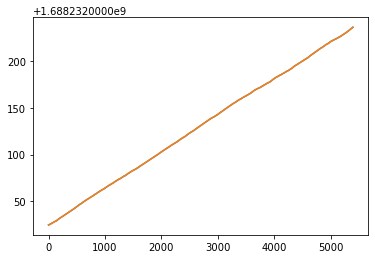

In [4]:
# synchronized_paths = cam_dm.getSyncronizedSamples()
for key in cam_dm.pixel_locations.keys():
    plt.plot(cam_dm.stamp_per_camera[key][cam_dm.syncMap('5000-0',key)[:,0]])

# Extrinsic Calibration Machine
Now that we have a nice wraper for the tracker cameras and their parameters, we use it to feed a machine that can estimate the mutal extrensics between camera pairs.

In [5]:
class EssentialMatrixEstimator():
    def __init__(self):
        self.estimation_mode=1
        self.inlier_threshold=0.07
    def create_row(self,point2,point1):
        u1=point1[0]
        v1=point1[1]
        u2=point2[0]
        v2=point2[1]
        line=np.array(\
        [u1*u2, u1*v2, u1, v1*u2, v1*v2, v1, u2, v2, 1]\
        ).reshape(1,9)
        return line
    def fit(self,data):
        rows=[]
        for i in range(len(data[0])):
            rows.append(self.create_row(data[0][i,:],data[1][i,:]))
        A=np.vstack(rows)
        u,s,v=np.linalg.svd(A)
        self.E=v.T[:,8].reshape(3,3).T
        u,s,v=np.linalg.svd(self.E)
        s[2]=0
        self.E=np.matmul(u * s, v)
        return self.E
    def get_performace(self,data):
        error=[]
        for i in range(len(data[0])):
            P1=np.hstack([data[0][i,:] ,1])
            P2=np.hstack([data[1][i,:] ,1])
            P1=P1.reshape(3,1)
            P2=P2.reshape(3,1)
            error.append(np.dot(np.dot(P2.T,self.E),P1))
        error=np.array(error).reshape(-1)
        cost=np.sum(error**2)
        return 1.0/cost
    def get_score(self,data,E):
        error=[]
        inliers=0
        for i in range(len(data[0])):
            P1=np.hstack([data[0][i,:] ,1])
            P2=np.hstack([data[1][i,:] ,1])
            P1=P1.reshape(3,1)
            P2=P2.reshape(3,1)
            dis=np.dot(np.dot(P2.T,E),P1)
            if np.abs(dis)<self.inlier_threshold:
                inliers=inliers+1
        return inliers
    def get_mask(self,data,E):
        mask=np.zeros((data[0].shape[0],1))
        for i in range(len(data[0])):
            P1=np.hstack([data[0][i,:] ,1])
            P2=np.hstack([data[1][i,:] ,1])
            P1=P1.reshape(3,1)
            P2=P2.reshape(3,1)
            dis=np.dot(np.dot(P2.T,E),P1)
            if np.abs(dis)<self.inlier_threshold:
                mask[i]=1
        return mask
    def fit_ransac(self,data, max_iters=100, samples_to_fit=8, inlierThreshold=None):    
        best_model = None
        max_number_of_inliers = 0
        if inlierThreshold is not None:
            self.inlier_threshold=inlierThreshold

        num_samples = data[0].shape[0]
        progress=[]
        for i in range(max_iters):
            samples = np.random.choice(num_samples, size=samples_to_fit, replace=False)
            model_params = self.fit([data[0][samples,:],data[1][samples,:]])
            number_of_inliers = self.get_score(data,model_params) #How many inliers for the given model?
            if number_of_inliers > max_number_of_inliers:
                best_model = model_params
                max_number_of_inliers = number_of_inliers
                progress.append(number_of_inliers)
        return progress,best_model

In [6]:
class geometricalExtrinsics():
    def __init__(self, cam_data_manager):
        self.cam_dm = cam_data_manager
        self.extrinsics = {}
        self.ess=EssentialMatrixEstimator()
        
    def getSkewMat(self, vec):
        return np.array([0, -vec[2], vec[1], vec[2], 0, -vec[0], -vec[1], vec[0], 0]).reshape(3,3)
    
    def getEssentialError(self, points1, points2, E):
        error=[]
        for i in range(points1.shape[0]):
            P1=np.hstack([points1[i,:] , 1.0])
            P2=np.hstack([points2[i,:] , 1.0])
            P1=P1.reshape(3,1)
            P2=P2.reshape(3,1)
            error.append(np.dot(np.dot(P2.T,E),P1))
        error=np.array(error).reshape(-1)
        return error
    
    def decomposeEandVerify(self, camiModel, camjModel, E, pi , pj ):
        '''
        Decompose the E matrix based on a modified verison of the rutine explained in: 
        https://stackoverflow.com/questions/22807039/decomposition-of-essential-matrix-validation-of-the-four-possible-solutions-for
        '''
        
        u,s,vt=np.linalg.svd(E)
        if np.linalg.det(u) < 0:
            u = -u
            
        if np.linalg.det(vt) < 0:
            vt = -vt
            
        W=np.array([0,-1,0,1,0,0,0,0,1],dtype='float32').reshape(3,3)
        R = u @ W @ vt
        t = u[...,-1].reshape(3,1)
        #Triangulate a sample point
        P1=np.dot(camiModel.P[0:3,0:3],np.hstack([np.eye(3),np.zeros((3,1))]))
        P2=np.dot(camjModel.P[0:3,0:3],np.hstack([R,t]))
        X1=cv2.triangulatePoints(P1,P2,pi[1000].reshape(-1,1,2),pj[1000].reshape(-1,1,2))
        X1=X1/X1[-1]
        X2=np.hstack([R,t])@X1
        #Are both at the back of the camera?
        if X1[2] * X2[2] < 0:
            print('the product turned out negative')
            R = u @ W.T @ vt
            #Triangulate with the fixed R
            P1=np.dot(camiModel.P[0:3,0:3],np.hstack([np.eye(3),np.zeros((3,1))]))
            P2=np.dot(camjModel.P[0:3,0:3],np.hstack([R,t]))
            X1=cv2.triangulatePoints(P1,P2,pi[1000].reshape(-1,1,2),pj[1000].reshape(-1,1,2))
            X1=X1/X1[-1]
        #is at tha back again?   
        if X1[2] < 0:
            t = -t
            #Update the P1 and P2
            P1=np.dot(camiModel.P[0:3,0:3],np.hstack([np.eye(3),np.zeros((3,1))]))
            P2=np.dot(camjModel.P[0:3,0:3],np.hstack([R,t]))
        #Triangulate all the points
        points=cv2.triangulatePoints(P1,P2,pi.reshape(-1,1,2),pj.reshape(-1,1,2))
        points_normalized=np.vstack([points[:,i]/points[-1,i] for i in range(len(points.T))])
        return P1, P2, R, t, points_normalized

        
    def getExtrinsics(self, cam_i, cam_j):
        #Do not recalculate the extrinsics multiple times. 
        try:
            return self.extrinsics[f'{cam_i},{cam_j}'] + (p1_pix, p2_pix)
        except:
            p1, p2 = cam_dm.getCovisibleMarkerPairs(cam_i, cam_j, undist= True ,normalized=True)
            p1_pix, p2_pix = cam_dm.getCovisibleMarkerPairs(cam_i, cam_j, undist=True, normalized=False)
            data=[p2.copy(),p1.copy()]
            E = self.ess.fit(data)
            error = self.getEssentialError(p1, p2, E)
            P1, P2, R, t, points_normalized = self.decomposeEandVerify(self.cam_dm.camModels[cam_i], self.cam_dm.camModels[cam_j],\
                                                                       E, p1_pix, p2_pix)
            self.extrinsics[f'{cam_i},{cam_j}'] = (E, P1, P2, R, t, points_normalized, error)
            return self.extrinsics[f'{cam_i},{cam_j}'] + (p1_pix, p2_pix)

gm_ext = geometricalExtrinsics(cam_dm)

In [7]:
cam_keys = [key for key in cam_dm.pixel_locations.keys()]
pairs = []
for i in range(len(cam_keys)-1):
    for j in range(i+1, len(cam_keys)):
        pairs.append([cam_keys[i], cam_keys[j]])
pairs

[['5000-0', '5000-1']]

the product turned out negative


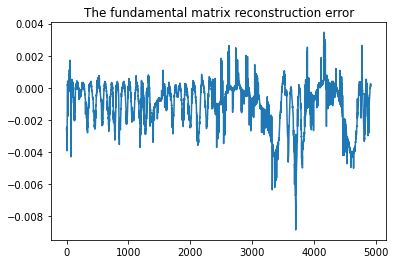

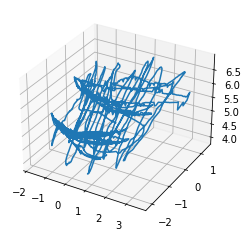

In [8]:
c1, c2 = '5000-0', '5000-1'
E, P1, P2, R, t, points_normalized, error, p1_pix, p2_pix = gm_ext.getExtrinsics(c1,c2)
params={
    'E':E,
    'P':(P1,P2),
    'R|T':(R,t),
    'E_error': error,
    'Recunstruction': (p1_pix, p2_pix, points_normalized)
}
with open(f'ext_{c1}->{c2}.pckl','wb') as f:
    pickle.dump(params, f)
    
    
plt.plot(error)
plt.title('The fundamental matrix reconstruction error')
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(points_normalized[:,0],points_normalized[:,1],points_normalized[:,2])
# plt.plot(points_normalized[:,1])
plt.show()


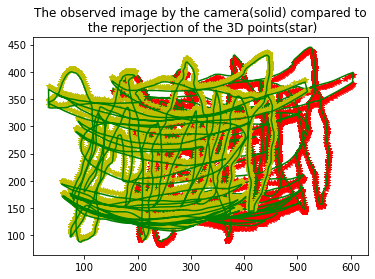

In [9]:
#Lets project the identified points on to the image plane to see if they match the expected model
reprojected1=np.dot(P1,points_normalized.T)
reprojected1=np.vstack([reprojected1[:,i]/reprojected1[-1,i] for i in range(len(reprojected1.T))])

reprojected2=np.dot(P2,points_normalized.T)
reprojected2=np.vstack([reprojected2[:,i]/reprojected2[-1,i] for i in range(len(reprojected2.T))])
plt.plot(reprojected1[:,0],reprojected1[:,1],'r*')
plt.plot(p1_pix[:,0],p1_pix[:,1],'g')

plt.plot(reprojected2[:,0],reprojected2[:,1],'y*')
plt.plot(p2_pix[:,0],p2_pix[:,1],'g')
plt.title('The observed image by the camera(solid) compared to\n the reporjection of the 3D points(star)')
plt.show()

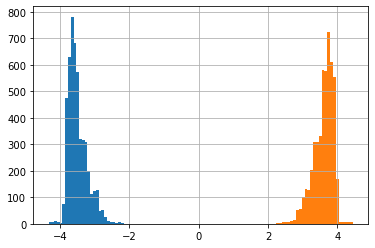

In [10]:
_ = plt.hist(np.mean(reprojected1[:,0:2]-p1_pix, axis=-1), bins=30)
_ = plt.hist(np.mean(reprojected2[:,0:2]-p2_pix, axis=-1), bins=30)
plt.grid(True)

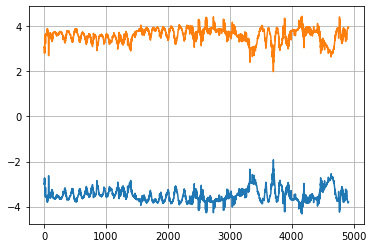

In [11]:
_ = plt.plot(np.mean(reprojected1[:,0:2]-p1_pix, axis=-1))
_ = plt.plot(np.mean(reprojected2[:,0:2]-p2_pix, axis=-1))
plt.grid(True)

## Generate Video with Epiline

In [12]:
def generateVidEpi(F, camera1_id, camera2_id, markers1, markers2, save_path):
    """
    Doc
    """
    fps = 20

    # Resolution of video = resolution of cameras
    size = (640, 480)

    # openCV text settings
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (20, 40)
    fontScale              = 0.7
    fontColor              = (255, 255, 255)
    thickness              = 1
    lineType               = 2

    # Video generation
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    vid = cv2.VideoWriter(os.path.join(save_path, f'EpiVid_{camera1_id}_{camera2_id}.avi'), fourcc, fps, size)

    # Asser len = len %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    for i in tqdm(range(len(markers1))):
        point1 = np.hstack((markers1[i, :], 1))
        point2 = np.hstack((markers2[i, :], 1))

        img1 = np.zeros((size[1],size[0],3)).astype(np.uint8)
        cv2.putText(img1, str(i), bottomLeftCornerOfText, font, fontScale, fontColor, thickness, lineType)

        if point2[0] != -1 :
            epl2 = (point2.reshape(1,3)@F).reshape(3,1)
            x1_strt = 0
            y1_strt = ((epl2[0]*x1_strt + epl2[2])/(-epl2[1]))[0]
            x1_end = size[0]
            y1_end = ((epl2[0]*x1_end + epl2[2])/(-epl2[1]))[0]

            strt = (int(round(x1_strt)), int(round(y1_strt)))
            end = (int(round(x1_end)), int(round(y1_end)))                
            clr = (0, 255, 0)
            thck = 1
            cv2.line(img1, strt, end, clr, thck)

        if point1[0] != -1 :
            cv2.circle(img1,(int(round(point1[0])), int(round(point1[1]))), 3, (0  ,0  ,255), -1)

        if point1[0] != -1 and point2[0] != -1:
            err1 = abs(point2.reshape(1,3)@F@point1.reshape(3,1))
            cv2.putText(img1, str(round(err1[0][0], 5)), (20, 70), font, fontScale, (0  ,0  ,255), thickness, lineType)

        vid.write(img1)

In [13]:
p1, p2 = cam_dm.getCovisibleMarkerPairs(c1, c2, undist= True ,normalized=True)
print(p1)

[[ 0.30489287 -0.3440105 ]
 [ 0.30462027 -0.34439182]
 [ 0.30399272 -0.34489825]
 ...
 [ 0.09182498 -0.0131319 ]
 [ 0.09991906 -0.01249359]
 [ 0.10817327 -0.01178691]]


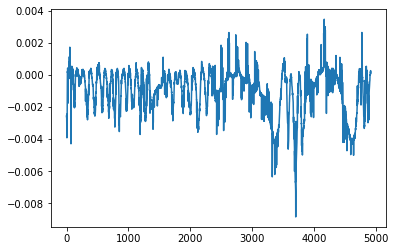

In [14]:
err = []
for i in range(len(p1)):
    pt1 = np.hstack((p1[i], 1)).reshape(3, 1)
    pt2 = np.hstack((p2[i], 1)).reshape(3, 1)
    err.append((pt2.T@E@pt1)[0])

plt.plot(err)

In [15]:
p1_pix, p2_pix = cam_dm.getCovisibleMarkerPairs(c1, c2, undist= True ,normalized=False)

print(np.shape(p1_pix))
print(p1_pix)

print(np.shape(p2_pix))
print(p2_pix)

(4920, 2)
[[462.02908 140.5354 ]
 [461.88687 140.33206]
 [461.55945 140.062  ]
 ...
 [350.866   316.97638]
 [355.08887 317.31677]
 [359.39532 317.6936 ]]
(4920, 2)
[[333.00732 128.63853]
 [332.80823 128.43248]
 [331.9477  128.1728 ]
 ...
 [227.38226 302.0664 ]
 [231.84221 302.2752 ]
 [236.08    302.5363 ]]


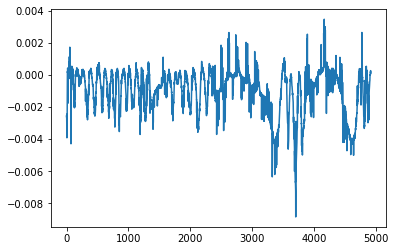

In [16]:
camera1_id = c1
camera2_id = c2
E = E
P1 = cam_dm.camModels[camera1_id].P
P1 = P1[:, 0:3]
P2 = cam_dm.camModels[camera2_id].P
P2 = P2[:, 0:3]
F = np.linalg.inv(P2.T)@E@np.linalg.inv(P1)

# F, masks = cv2.findFundamentalMat(p1_pix, p2_pix, cv2.RANSAC)

err = []
for i in range(len(p1_pix)):
    pt1 = np.hstack((p1_pix[i], 1)).reshape(3, 1)
    pt2 = np.hstack((p2_pix[i], 1)).reshape(3, 1)
    err.append((pt2.T@F@pt1)[0])

plt.plot(err)

In [17]:
save_path = 'generatedVid'
generateVidEpi(F, camera1_id, camera2_id, p1_pix, p2_pix, save_path)
print('Done!')

100%|██████████████████████████████████████| 4920/4920 [00:08<00:00, 585.48it/s]

Done!


## Compute The Extrinsics for All of The pairs

the product turned out negative
['5000-0', '5000-1']


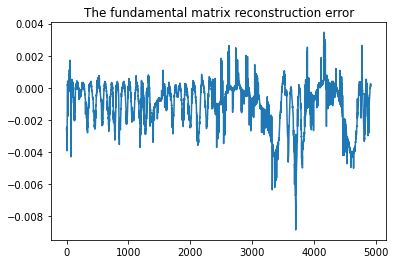

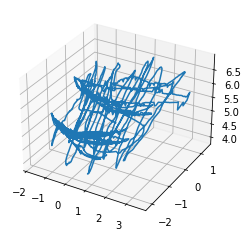

In [18]:
root = '.'
for pair in pairs:
    c1, c2 = pair
    E, P1, P2, R, t, points_normalized, error, p1_pix, p2_pix = gm_ext.getExtrinsics(c1,c2)
    params={
        'E':E,
        'P':(P1,P2),
        'R|T':(R,t),
        'E_error': error,
        'Recunstruction': (p1_pix, p2_pix, points_normalized)
    }
    with open(os.path.join(root, f'ext_{c1}->{c2}.pckl'),'wb') as f:
        pickle.dump(params, f)

    print(pair)
    plt.plot(error)
    plt.title('The fundamental matrix reconstruction error')
    plt.show()

    plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot3D(points_normalized[:,0],points_normalized[:,1],points_normalized[:,2])
    # plt.plot(points_normalized[:,1])
    plt.show()
